# Feature Selection
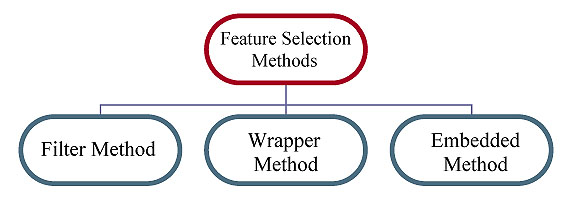

# Setup

In [1]:
!conda install mlxtend --yes

Solving environment: \ 
  - https://repo.continuum.io/pkgs/main/osx-64::cvxcanon-0.1.1-py36h6440ff4_0
  - defaults::cvxcanon-0.1.1-py36h6440ff4done

# All requested packages already installed.



In [36]:
import math
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from feature_engine.categorical_encoders import OneHotCategoricalEncoder

# Data
* AllState Kaggle Competition (https://www.kaggle.com/c/allstate-claims-severity)

In [3]:
df = pd.read_csv('allstate.csv')
df.shape

(188318, 132)

In [4]:
df.dtypes

id          int64
cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
cat6       object
cat7       object
cat8       object
cat9       object
cat10      object
cat11      object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cat19      object
cat20      object
cat21      object
cat22      object
cat23      object
cat24      object
cat25      object
cat26      object
cat27      object
cat28      object
cat29      object
           ...   
cat102     object
cat103     object
cat104     object
cat105     object
cat106     object
cat107     object
cat108     object
cat109     object
cat110     object
cat111     object
cat112     object
cat113     object
cat114     object
cat115     object
cat116     object
cont1     float64
cont2     float64
cont3     float64
cont4     float64
cont5     float64
cont6     float64
cont7     float64
cont8     float64
cont9     float64
cont10    

In [5]:
df.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  2763.85  

[5 rows x 132 columns]

# EDA
* Profile a small sample

In [6]:
pandas_profiling.ProfileReport(df[0:5000].copy())

# Pipeline

In [7]:
data = df[0:5000].copy()
y = data['loss']
X = data.drop(columns=['loss', 'id'])
X = X.fillna('MISSING')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)

In [8]:
catColumns = X_train.select_dtypes(include='object').columns.tolist()
numColumns = X_train.select_dtypes(include='number').columns.tolist()

In [9]:
X_train_num = X_train[numColumns]
X_test_num  = X_test[numColumns]

X_train_cat = X_train[catColumns]
X_test_cat  = X_test[catColumns]

scaler = StandardScaler()
ohe    = OneHotCategoricalEncoder(variables=catColumns)

X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns = X_train_num.columns)
X_train_num = X_train_num.reset_index(drop=True)
X_test_num  = pd.DataFrame(scaler.transform(X_test_num), columns = X_train_num.columns)
X_test_num = X_test_num.reset_index(drop=True)

X_train_cat = ohe.fit_transform(X_train_cat)
X_train_cat = X_train_cat.reset_index(drop=True)
X_test_cat  = ohe.transform(X_test_cat)
X_test_cat  = X_test_cat.reset_index(drop=True)

X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test  = pd.concat([X_test_num, X_test_cat], axis=1)

# Loss

In [10]:
def evaluate(truth, pred):
    mae  = mean_absolute_error(truth, pred)
    mse  = mean_squared_error(truth, pred)
    rmse = math.sqrt(mse)
    return (mae, mse, rmse)

resultsDF = pd.DataFrame(columns=['Technique', 'Method', 'MAE', 'RMSE', 'Features'])

# Baseline
* For each technique we fit a RandomForest Regressor
* Capture MAE, RMSE and number of features
* Number of features affect training time

In [114]:
rf = RandomForestRegressor(random_state=1337)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Baseline'] = ['None', 'Baseline', mae, rmse, X_train.shape[1]]

MAE  : 1439.43
RMSE : 2144.14


# Filter

## Highly Correlated
* Highly correlated features can lead to overfitting
* We can remove highly correlated variables without the loss of much information
* EDA indicated:
 * cont12 and cont11 highly correlated
 * cont9 and cont1 highly correlated

In [126]:
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
features_to_remove = [column for column in upper.columns if any(upper[column] > 0.95)]

In [127]:
print(features_to_remove) # Note 0.95 > Cont9 > 0.90
X_train_new = X_train.drop(columns=features_to_remove, axis=1)
X_test_new = X_test.drop(columns=features_to_remove, axis=1)

['cont12', 'cat1_B', 'cat2_A', 'cat3_B', 'cat4_B', 'cat5_B', 'cat6_B', 'cat7_A', 'cat8_A', 'cat9_A', 'cat10_A', 'cat11_A', 'cat12_A', 'cat13_A', 'cat14_B', 'cat16_B', 'cat17_B', 'cat18_B', 'cat19_B', 'cat20_B', 'cat21_B', 'cat22_B', 'cat23_B', 'cat24_B', 'cat25_B', 'cat26_B', 'cat27_B', 'cat28_B', 'cat29_B', 'cat30_B', 'cat31_B', 'cat32_B', 'cat33_B', 'cat34_B', 'cat35_B', 'cat36_B', 'cat37_B', 'cat38_B', 'cat39_B', 'cat40_B', 'cat41_B', 'cat42_B', 'cat43_B', 'cat44_B', 'cat45_B', 'cat46_B', 'cat47_B', 'cat48_B', 'cat49_B', 'cat50_B', 'cat51_B', 'cat52_B', 'cat53_B', 'cat54_B', 'cat55_B', 'cat56_B', 'cat57_A', 'cat58_B', 'cat59_B', 'cat60_B', 'cat61_B', 'cat62_B', 'cat64_B', 'cat65_B', 'cat66_A', 'cat67_B', 'cat68_B', 'cat69_B', 'cat71_B', 'cat72_A', 'cat73_B', 'cat74_B', 'cat75_A', 'cat76_B', 'cat78_A', 'cat80_A', 'cat81_A', 'cat85_A', 'cat87_A', 'cat88_A', 'cat89_B', 'cat89_A', 'cat89_E', 'cat90_A', 'cat90_B', 'cat90_F', 'cat92_H', 'cat93_C', 'cat98_A', 'cat98_E', 'cat99_T', 'cat99_P

In [136]:
# Predict & Score
rf = RandomForestRegressor(random_state=202)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Filter:Correlated'] = ['Filter', 'Correlated', mae, rmse, X_train_new.shape[1]]

MAE  : 1457.55
RMSE : 2212.72


## Select Percentile
* Univariate Method
* Choose your scoring method
 * F-Value between label / feature
 * Mutual Information
* Other selection apporaches
 * Select K Best (fixed number)
 * Select From Model (choose from importance or coefficients)

### F Score - Regression
* Use a linear model for testing the individual effect of a regressor
* Scoring function:
 * Correlation between regressor & target computed
 * Convert to F score
 * Convert to p-value
 * Take top (n) or percentile of features
* For this example. pick upper 10th percentile (~80 features)
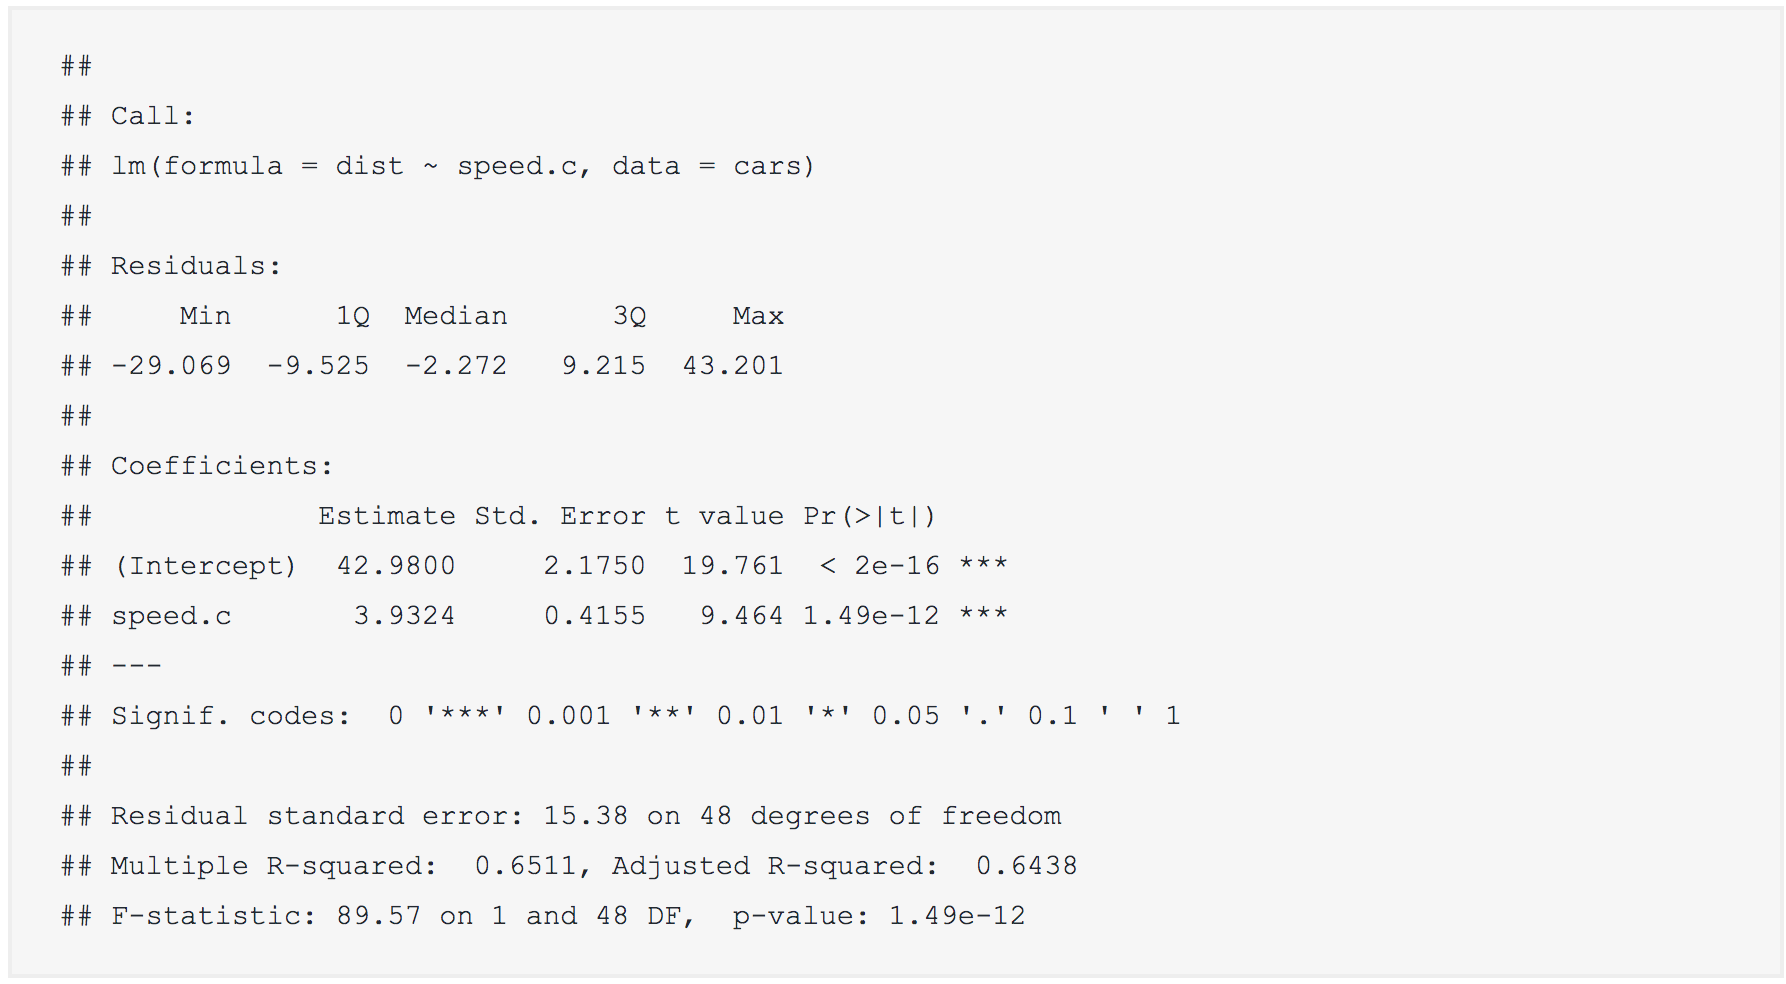

In [15]:
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(X_train, y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

In [16]:
cols   = X_train.columns[selector.get_support()]
pvals  = selector.pvalues_[selector.get_support()]
scores = -np.log10(pvals)
scores /= scores.max()
featuresFRegDF = pd.DataFrame({'Column': cols, 'P-Value': pvals, 'Score': scores})
featuresFRegDF.sort_values('Score', ascending=False)
featuresFRegDF = featuresFRegDF.reset_index(drop=True)
featuresFRegDF['Rank'] = featuresFRegDF.index + 1
featuresFRegDF.head()

Column       P-Value     Score  Rank
0   cont2  6.479934e-18  0.071066     1
1   cont3  5.117963e-17  0.067355     2
2   cont7  1.821179e-19  0.077480     3
3  cont11  3.057156e-15  0.060012     4
4  cont12  7.965805e-16  0.062427     5

In [17]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Filter:F-Score'] = ['Filter', 'F-Score', mae, rmse, X_train_new.shape[1]]

MAE  : 1499.71
RMSE : 2228.39


### Mutual Information
* Mutual information measues how much a random variable tells us about another
* For example, knowing wind speed could help us guess if a flight will be delayed
 * It won't tell us perfectly
 * But it could make our guess better
 * The degree to to which our guess is better are explained / measured with mutual information
* Note:
 * Mutual information is not correlation
 * Mutual information is more like information gain
 * Mutual information is a distance between probability distributions
 * Correlation measures the linear relationship between two random variables
* In this example, pick upper 10th percentile (about 80 features)

In [18]:
selector = SelectPercentile(mutual_info_regression, percentile=10)
selector.fit(X_train, y_train)
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

In [19]:
cols   = X_train.columns[selector.get_support()]
scores = selector.scores_[selector.get_support()]
scores /= scores.max()
featuresMutDF = pd.DataFrame({'Column': cols, 'Score': scores})
featuresMutDF.sort_values('Score', ascending=False)
featuresMutDF = featuresMutDF.reset_index(drop=True)
featuresMutDF['Rank'] = featuresMutDF.index + 1
featuresMutDF.head()

Column     Score  Rank
0   cont2  0.213822     1
1   cont3  0.078747     2
2   cont5  0.134057     3
3   cont7  0.156045     4
4  cont10  0.109367     5

In [20]:
# Predict & Score
rf = RandomForestRegressor()
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Filter:MutualInformation'] = ['Filter', 'Mutual Information', mae, rmse, X_train_new.shape[1]]

MAE  : 1484.96
RMSE : 2269.44


### Comparison

In [21]:
combineRegDF = featuresFRegDF[['Column', 'Score', 'Rank']]
combineRegDF = combineRegDF.rename(columns={'Score': 'FReg:Score', 'Rank':'FReg:Rank'})
combineMutDF = featuresMutDF[['Column', 'Score', 'Rank']]
combineMutDF = combineMutDF.rename(columns={'Score': 'Mut:Score', 'Rank':'Mut:Rank'})

featuresDF = pd.merge(left=combineRegDF, right=combineMutDF, how='outer',
                      left_on='Column', right_on='Column')
featuresDF

Column  FReg:Score  FReg:Rank  Mut:Score  Mut:Rank
0       cont2    0.071066        1.0   0.213822       1.0
1       cont3    0.067355        2.0   0.078747       2.0
2       cont7    0.077480        3.0   0.156045       4.0
3      cont11    0.060012        4.0        NaN       NaN
4      cont12    0.062427        5.0   0.112035       6.0
5      cat1_A    0.170950        6.0   0.257069       8.0
6      cat1_B    0.170950        7.0   0.257069       9.0
7      cat2_B    0.188197        8.0   0.225834      10.0
8      cat2_A    0.188197        9.0   0.226150      11.0
9      cat3_A    0.144430       10.0   0.114887      12.0
10     cat3_B    0.144430       11.0   0.114887      13.0
11     cat4_A    0.050528       12.0   0.105159      14.0
12     cat4_B    0.050528       13.0   0.105122      15.0
13     cat7_B    0.333011       14.0   0.225170      20.0
14     cat7_A    0.333011       15.0   0.225170      21.0
15     cat9_B    0.176220       16.0   0.214436      22.0
16     cat9_A    0.176220       17.0   0.214518      23.0
17    cat10_B    0.334417       18.0   0.329067      24.0
18    cat10_A    0.334417       19.0   0.328710      25.0
19    cat11_B    0.229233       20.0   0.233992      26.0
20    cat11_A    0.229233       21.0   0.233992      27.0
21    cat12_B    0.460972       22.0   0.431402      28.0
22    cat12_A    0.460972       23.0   0.431428      29.0
23    cat13_B    0.254140       24.0   0.190089      30.0
24    cat13_A    0.254140       25.0   0.190089      31.0
25    cat16_A    0.151273       26.0   0.139476      32.0
26    cat16_B    0.151273       27.0   0.136177      33.0
27    cat23_A    0.122681       28.0   0.171137      34.0
28    cat23_B    0.122681       29.0   0.171003      35.0
29    cat24_A    0.061538       30.0        NaN       NaN
..        ...         ...        ...        ...       ...
67   cat100_I    0.149685       68.0   0.202676      70.0
68   cat100_G    0.106083       69.0   0.109107      71.0
69   cat100_L    0.038727       70.0   0.080804      72.0
70   cat101_O    0.105256       71.0   0.093774      74.0
71   cat101_A    0.188197       72.0   0.225944      75.0
72   cat101_I    0.055831       73.0   0.102435      76.0
73   cat101_L    0.060323       74.0        NaN       NaN
74   cat101_Q    0.118383       75.0   0.110395      77.0
75   cat101_J    0.039441       76.0        NaN       NaN
76   cat101_M    0.087890       77.0   0.078684      78.0
77   cat105_L    0.074598       78.0        NaN       NaN
78  cat109_BI    0.043605       79.0        NaN       NaN
79   cat111_A    0.050528       80.0   0.105189      80.0
80   cat113_E    0.152971       81.0        NaN       NaN
81  cat116_KT    0.064872       82.0        NaN       NaN
82   cat116_R    0.152971       83.0        NaN       NaN
83      cont5         NaN        NaN   0.134057       3.0
84     cont10         NaN        NaN   0.109367       5.0
85     cont14         NaN        NaN   0.134834       7.0
86     cat5_A         NaN        NaN   0.105277      16.0
87     cat5_B         NaN        NaN   0.105344      17.0
88     cat6_A         NaN        NaN   0.111633      18.0
89     cat6_B         NaN        NaN   0.111614      19.0
90    cat50_A         NaN        NaN   0.181409      44.0
91    cat50_B         NaN        NaN   0.181410      45.0
92   cat100_H         NaN        NaN   0.075163      73.0
93   cat103_A         NaN        NaN   0.105262      79.0
94   cat114_A         NaN        NaN   0.111817      81.0
95   cat114_E         NaN        NaN   0.081817      82.0
96   cat114_C         NaN        NaN   0.148274      83.0

[97 rows x 5 columns]

## Variance Threshold
* With variance threshold we're trying to remove features with near zero variance
* Near zero variance often equates to a poor predictor 

In [120]:
selector = VarianceThreshold()
selector.fit(X_train)
selector.get_support()
X_train_new = selector.transform(X_train)
X_test_new  = selector.transform(X_test)

In [121]:
# Predict & Score
rf = RandomForestRegressor(random_state=1337)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Filter:VarianceThreshold'] = ['Filter', 'VarianceThreshold', mae, rmse, X_train_new.shape[1]]

MAE  : 1437.75
RMSE : 2167.91


# Embedded
* Embedded method use a model to locate the best features.
* Broad approaches 
 * Sparsity - Lasso
 * Importance - Random Forest
 * Coefficients - Linear Models, SVC / SVR (different than zero)

## Lasso Regression
* Skip fitting an intercept

In [74]:
lassoReg = Lasso(fit_intercept=False)
lassoReg.fit(X_train, y_train)
coefficients = lassoReg.coef_

In [75]:
support = coefficients > 0
cols = X_train.columns[support]
X_train_new = X_train[cols]
X_test_new = X_test[cols]

In [77]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Embedded:Lasso'] = ['Embedded', 'Lasso', mae, rmse, X_train_new.shape[1]]

MAE  : 1438.79
RMSE : 2209.33


## Random Forest Importance
* Common to fit a random forest to look at importance

In [39]:
estimator = RandomForestRegressor(random_state=1337)
selector = SelectFromModel(estimator, )
selector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators='warn',
                                                n_jobs=None, oob_score=False,
                                                random_state=None, verbose=0,
                                                warm_start=False),
                max_features=None, norm_order=1, prefit=False,

In [40]:
cols = X_train.columns[(selector.get_support())]
X_train_new = X_train[cols]
X_test_new  = X_test[cols]

In [41]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Embedded:RandomForest'] = ['Embedded', 'RandomForest', mae, rmse, X_train_new.shape[1]]

MAE  : 1446.07
RMSE : 2220.53


In [59]:
features = {}
for feature, importance in zip(X_train_new.columns, rf.feature_importances_):
    features[feature] = importance
importanceDF = pd.DataFrame.from_dict(features, orient='index')
importanceDF.sort_values(by=0, ascending=False).head(10)

0
cat80_B  0.241115
cont2    0.063566
cont7    0.052857
cont14   0.046801
cont3    0.034384
cat57_A  0.032774
cont4    0.025431
cont12   0.025011
cont8    0.024545
cont13   0.021796

Text(0.5, 1.0, 'Top 25 Important Features')

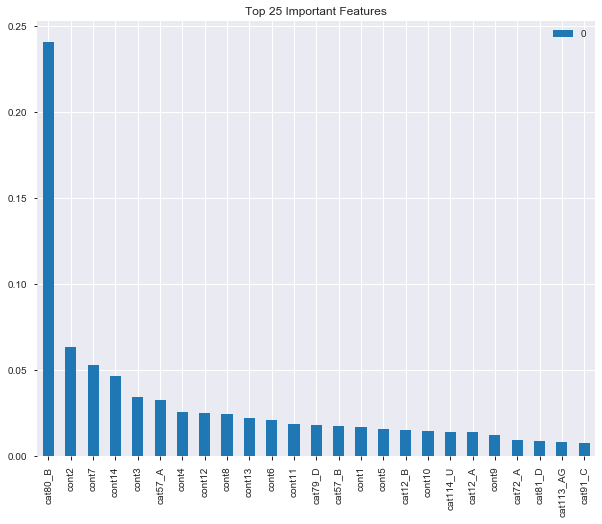

In [60]:
importanceDF.sort_values(by=0, ascending=False)[0:25].plot(kind='bar', rot=90, figsize=(10, 8))
plt.title('Top 25 Important Features')

# Wrapper

## Recursive Feature Elimination
* We start with a full model (all features)
* We then remove one feature and construct a model
* Greedily select the model with the lowest error
* Repeat until desired number of features or precisin is met

In [80]:
estimator = SVR(kernel="linear")
selector = RFE(estimator, 80, step=10, verbose=1)
selector = selector.fit(X_train, y_train)

Fitting estimator with 828 features.
Fitting estimator with 818 features.
Fitting estimator with 808 features.
Fitting estimator with 798 features.
Fitting estimator with 788 features.
Fitting estimator with 778 features.
Fitting estimator with 768 features.
Fitting estimator with 758 features.
Fitting estimator with 748 features.
Fitting estimator with 738 features.
Fitting estimator with 728 features.
Fitting estimator with 718 features.
Fitting estimator with 708 features.
Fitting estimator with 698 features.
Fitting estimator with 688 features.
Fitting estimator with 678 features.
Fitting estimator with 668 features.
Fitting estimator with 658 features.
Fitting estimator with 648 features.
Fitting estimator with 638 features.
Fitting estimator with 628 features.
Fitting estimator with 618 features.
Fitting estimator with 608 features.
Fitting estimator with 598 features.
Fitting estimator with 588 features.
Fitting estimator with 578 features.
Fitting estimator with 568 features.
F

In [81]:
X_train_new = selector.transform(X_train)
X_test_new  = selector.transform(X_test)

In [82]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Wrapper:RFE'] = ['Wrapper', 'RFE', mae, rmse, X_train_new.shape[1]]

MAE  : 1463.27
RMSE : 2215.05


## Sequential Forward Selection
* There isn't a forward selection in sklearn
* The mlxtend library has a robust implementation
 * Parallel
 * Plotting
 * Target range
 * Includes float (https://www.sciencedirect.com/science/article/pii/0167865594901279)
* With SFS we start with an empty model
* Build a separate model for each additional feature
* Greedily select best model
* Repeat until desired number of features or precision reached

In [106]:
estimator = LinearRegression()
sfs = SFS(estimator,
         k_features=80,
         forward=True,
         floating=False,
         verbose=2,
         scoring='neg_mean_squared_error',
         n_jobs=-1,
         cv=0)

In [107]:
sfsModel = sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 828 out of 828 | elapsed:    0.3s finished

[2019-10-30 20:08:21] Features: 1/80 -- score: -6416706.87302631[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 827 out of 827 | elapsed:    0.3s finished

[2019-10-30 20:08:21] Features: 2/80 -- score: -5980323.971271509[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.4s finished

[2019-10-30 20:08:22] Features: 3/80 -- score: -5644577.549045111[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 825 out of

[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 798 out of 798 | elapsed:    1.2s finished

[2019-10-30 20:08:44] Features: 31/80 -- score: -3815224.1444222173[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 797 out of 797 | elapsed:    1.3s finished

[2019-10-30 20:08:45] Features: 32/80 -- score: -3798996.0077554802[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 796 out of 796 | elapsed:    1.3s finished

[2019-10-30 20:08:47] Features: 33/80 -- score: -3783428.019034807[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    1.4s finished

[2019-10-30 20:08:48] Features: 34/8

[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed:    4.0s finished

[2019-10-30 20:09:50] Features: 59/80 -- score: -3511886.528608413[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 769 out of 769 | elapsed:    4.0s finished

[2019-10-30 20:09:54] Features: 60/80 -- score: -3505648.666393753[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 768 out of 768 | elapsed:    4.2s finished

[2019-10-30 20:09:58] Features: 61/80 -- score: -3499563.4787224224[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | el

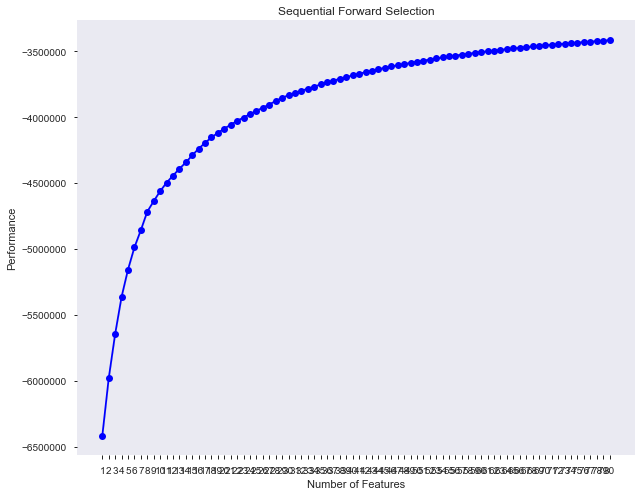

In [110]:
plot_sfs(sfsModel.get_metric_dict(), figsize=(10,8))
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()

In [111]:
features = list(sfsModel.subsets_[80]['feature_names'])
X_train_new = X_train[features]
X_test_new  = X_test[features]

In [112]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Wrapper:SFS'] = ['Wrapper', 'SFS', mae, rmse, X_train_new.shape[1]]

MAE  : 1436.55
RMSE : 2204.77


## Sequential Forward Floating Selection
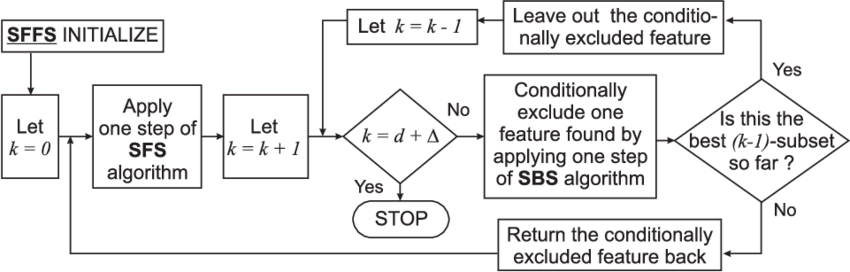

In [100]:
estimator = LinearRegression()
sffs = SFS(estimator,
         k_features=80,
         forward=True,
         floating=True,
         verbose=2,
         scoring='neg_mean_squared_error',
         n_jobs=-1,
         cv=0)

In [101]:
sffsModel = sffs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 828 out of 828 | elapsed:   14.6s finished

[2019-10-30 20:01:48] Features: 1/80 -- score: -6416706.87302631[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 827 out of 827 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2019-10-30 20:01:48] Features: 2/80 -- score: -5980323.971271509[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 826 out of 826 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1

[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 811 out of 811 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2019-10-30 20:01:58] Features: 18/80 -- score: -4153223.9606044483[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2019-10-30 20:01:59] Features: 19/80 -- score: -411

[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.2s finished

[2019-10-30 20:02:16] Features: 33/80 -- score: -3783428.019034807[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 795 out of 795 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:    0.2s finished

[2019-10-30 20:02:18] Features: 34/80 -- score: -3767213.656244835[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 794 out of 794 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    0.2s finished

[2019-10-30 20:02:20] Features: 35/80 -- score: -3751463.4807139216[Parallel(n_job

[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 778 out of 778 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished

[2019-10-30 20:03:01] Features: 51/80 -- score: -3570331.4136369536[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 777 out of 777 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  51 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:    0.3s finished

[2019-10-30 20:03:05] Features: 52/80 -- score: -3562288.929829127[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent 

[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 748 out of 763 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 763 out of 763 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.6s finished

[2019-10-30 20:04:06] Features: 66/80 -- score: -3473043.0801807987[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 762 out of 762 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    0.6s finished

[2019-10-30 20:04:11] Features: 67/80 -- score: -3468129.5049798596[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel

In [102]:
features = list(sffsModel.subsets_[80]['feature_names'])
X_train_new = X_train[features]
X_test_new  = X_test[features]

In [104]:
# Predict & Score
rf = RandomForestRegressor(random_state=999)
rf.fit(X_train_new, y_train)
pred = rf.predict(X_test_new)
mae, mse, rmse = evaluate(y_test, pred)
print('MAE  : {:.2f}'.format(mae))
print('RMSE : {:.2f}'.format(rmse))
resultsDF.loc['Wrapper:SFFS'] = ['Wrapper', 'SFFS', mae, rmse, X_train_new.shape[1]]

MAE  : 1436.55
RMSE : 2204.77


# Results
* RFE could have performed better (but I took steps=10)
* Note:  
 * These MAE values are quite close
 * For a production analysis - definitely add CV or more trees to our RF evaluator
 * We don't want to be unlucky on a given model

In [137]:
resultsDF.sort_values('MAE', ascending=True)

Technique              Method          MAE  \
Wrapper:SFS                Wrapper                 SFS  1436.546062   
Wrapper:SFFS               Wrapper                SFFS  1436.546062   
Filter:VarianceThreshold    Filter   VarianceThreshold  1437.754837   
Embedded:Lasso            Embedded               Lasso  1438.789246   
Baseline                      None            Baseline  1439.432420   
Embedded:RandomForest     Embedded        RandomForest  1446.071570   
Filter:Correlated           Filter          Correlated  1457.545445   
Wrapper:RFE                Wrapper                 RFE  1463.268357   
Filter:MutualInformation    Filter  Mutual Information  1484.958413   
Filter:F-Score              Filter             F-Score  1499.707535   

                                 RMSE  Features  
Wrapper:SFS               2204.768571        80  
Wrapper:SFFS              2204.768571        80  
Filter:VarianceThreshold  2167.912326       825  
Embedded:Lasso            2209.326499       218  
Baseline                  2144.138758       828  
Embedded:RandomForest     2220.533264       113  
Filter:Correlated         2212.720919       711  
Wrapper:RFE               2215.054837        80  
Filter:MutualInformation  2269.444174        83  
Filter:F-Score            2228.385553        83

# Conclusion
* Three techniques (F.E.W.)
 * Filter - Score variables and filter
 * Embedded - Look at models that can identify the best features
 * Wrapper - Iteratively build or remove features to find best collection
* Not PCA (But they both do a similar thing)
 * Feature Selection reduces dimensionality without changing features
 * PCA transforms (projects) features into a lower dimension space
* Sklearn SelectFromModel (SelectKBest, SelectPercentile) can be placed in pipelines
* No free lunch (as always) 
 * My default is building a full model
 * Look at variable importance
 * Apply RFE or Embedded (with importance)
 * I'm skeptical of univariate methods in general 
   * Greedy
   * Interactions can be meaningful
   * Rather fight overfitting than underfitting
* Mlxtend worth a closer look!